<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/gaussian-processes/02-fitting-gaussian-processes-pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Gaussian Process Model in PyMC3

A commong applied task involves building regression models to characterize non-linear relatioshipts between variables. It is possible to fit such models by assuming a particular non-linear structure, such as sinusoidal, exponential or pulynomical function, to descrive a given response by one variable to another. A non-parametric approach can be adopted be defining a set of knots accross the variable space and use a spline or kernel regression to describe arbitrary non-linear relationships. Alternatively, a Bayesian non-parametric strategy can be adopted and directl model the unknown underlying function.

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the fundamental first step in Bayesian modeling is to specify a full probability model for the problem at hand, assigning probability densities to all unknown quantities of interest. So, it is difficult to explicitly state a full probability model without the use of probability functions, which are parametric! It turns out that Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are infinitely parametric.


## Building models with Gaussians

What if we chose to use Gaussian distributions to model our data?

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$
There would not seem to be an advantage to doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} &amp; {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} &amp; {\Sigma_y}  \\
\end{array}
}\right]\right)$$$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$
Also, conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$
A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, any finite subset of which have a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially specifying an infinte vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a disribution over functions. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$
It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed.

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &amp;=0 \\
k(x,x^{\prime}) &amp;= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$
here, the covariance function is a squared exponential, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process -- surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

In [2]:
!nvidia-smi

Thu Oct  3 14:09:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!git clone https://github.com/martin-fabbri/colab-notebooks

Cloning into 'colab-notebooks'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 398 (delta 17), reused 5 (delta 2), pack-reused 364
Receiving objects: 100% (398/398), 9.65 MiB | 26.69 MiB/s, done.
Resolving deltas: 100% (216/216), done.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import pymc3 as pm
import scipy as sp
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_context('talk')

np.random.seed(42)

### Squared Exponential Covariance

$$\begin{aligned}
k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

In [0]:
def exponential_cov(x, y, params):
  """
  params -> theta(i)
  """
  return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x, y)**2)


### Sampling from a Gaussian Process

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$
And this the function that implements it:

In [0]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())
  

We will start with a Gaussian process prior with hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

(-3, 3)

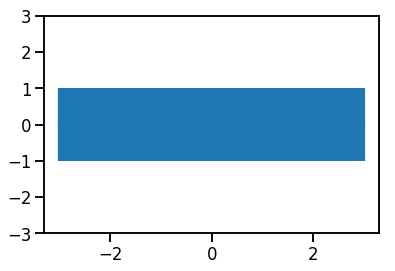

In [7]:
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)

plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.ylim(-3, 3)

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no prevous points, we can sample from an unconditional Gaussian:

In [8]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
y

[0.4967141530112327]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$.

In [9]:
σ_1 = exponential_cov(x, x, θ)
σ_1

array([[1.]])

In [0]:
def predict(x, data, kernel, params, sigma, t):
  k = [kernel(x, y, params) for y in data]
  Sinv = np.linalg.inv(sigma)
  y_pred = np.dot(k, Sinv).dot(t)
  sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
  return y_pred, sigma_new


In [11]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]
predictions[:3]

[(8.964952284247832e-36, 1.0),
 (1.1397370424705615e-35, 1.0),
 (1.4484539263965649e-35, 1.0)]

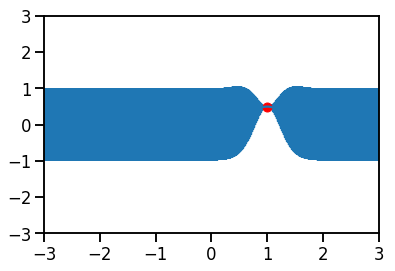

In [12]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

So conditional on this point, and the covariance structure we gave specified, we have essentialy contrained the probable location of additional points. Let's sample another.

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$


In [19]:
m, s = conditional([-0.7], x, y, θ)
print('m, s:', m, s)
y2 = np.random.normal(m, s)
print('y2:', y2)

m, s: 2.633608839077871e-07 0.9999999999997189
y2: 0.496714416371977


This point is added to the realization, and can ve used to further update the location of the next point.

In [0]:
x.append(-0.7)
y.append(y2)